Use this notebook to evaluate the working of the `CVTrainedModel`. The notebook uses the same logic/implementation as you would find inside the `CVTrainedModel` class.

In [1]:
import datajoint as dj
import numpy as np
import torch
from torch.autograd import Variable
from torch.nn.init import normal, constant
from torch import nn
from matplotlib import pyplot as plt
from attorch.train import early_stopping
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)
from v1_likelihood.train import CVSet, BinConfig, LinearRegression, CleanContrastSessionDataSet, binnify, CVTrainedModel, ModelDesign
from v1_likelihood.models import Net
from v1_likelihood.utils import set_seed

%matplotlib inline

from numpy.linalg import inv

from v1_likelihood import train, analysis

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Connecting eywalker@10.28.0.34:3306


In [2]:
train.BestRefinedModel().populate((train.BinConfig() & 'bin_counts = 91').proj())

In [2]:
keys = train.BestRecoveredModel().fetch('KEY')

In [8]:
key = keys[129]

In [9]:
train.BestRecoveredModel() & key

csc_hash hash for clean spike count set,dataset_contrast contrast of the stimulus,cv_seed seed for the cv set,cv_config_id id for config,bin_config_id id,model_id model id,param_id ID of parameter,train_seed training seed,cnn_train_score score on train set,cnn_valid_score score on test set,cnn_target_train_score score expected on train set,cnn_target_valid_score score expected on the validation set,avg_sigma average width of the likelihood functions,model trained model
4ed2dadf906380a1dd9b8e613cf3f4e88891f170,0.01,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,60993fbe03e405d2e8a3b5ff3a3da0ab,f58ddb32f1b04b7e83df242ddc90260c,92,9.60543,10.7782,9.60543,10.7782,36.6974,=BLOB=


In [11]:
train.BestRecoveredModel()

csc_hash hash for clean spike count set,dataset_contrast contrast of the stimulus,cv_seed seed for the cv set,cv_config_id id for config,bin_config_id id,model_id model id,param_id ID of parameter,train_seed training seed,cnn_train_score score on train set,cnn_valid_score score on test set,cnn_target_train_score score expected on train set,cnn_target_valid_score score expected on the validation set,avg_sigma average width of the likelihood functions,model trained model
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,e1b77e134717fc53615328dffe1243b8,0e5480f3b207dfcc20d54c41545d85ac,8,10.9246,11.3466,10.9246,11.3466,29.0383,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.04,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,778d8d2b08f9c2c3caed73dc00b4e1e8,92,3.42833,4.41531,3.42833,4.41531,7.35372,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.32,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,d509984657be5d4870a7ae4dd3bc4eb2,8c1bd7a7ecfebc132a288b6cfd5880ac,123,1.89359,2.4384,1.89359,2.4384,11.3634,=BLOB=
0732f2b73f4900ee4fa81f8853b48e460a42ee14,0.02,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,e1b77e134717fc53615328dffe1243b8,fd90e9c867b9f98188f89383664d5618,92,3.5788,4.53137,3.5788,4.53137,9.8894,=BLOB=
0732f2b73f4900ee4fa81f8853b48e460a42ee14,0.16,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,60993fbe03e405d2e8a3b5ff3a3da0ab,6759de0e91c3c15e1ac1657cb01f842e,92,2.11137,2.3138,2.11137,2.3138,3.46429,=BLOB=
0732f2b73f4900ee4fa81f8853b48e460a42ee14,1,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,778d8d2b08f9c2c3caed73dc00b4e1e8,8,1.29965,1.43314,1.29965,1.43314,2.64818,=BLOB=
0821d6c856639dcb7bb67b1dc8d0f2339b60e27f,0.01,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,e1b77e134717fc53615328dffe1243b8,dbb6abc60c941ca01036d06a336c7925,8,6.85865,8.47981,6.85865,8.47981,23.631,=BLOB=


In [12]:
train.BestModelByBin().insert(train.BestRecoveredModel(), ignore_extra_fields=True)

In [13]:
train.BestModelByBin() & (train.BinConfig & 'bin_counts = 91')

csc_hash hash for clean spike count set,dataset_contrast contrast of the stimulus,cv_seed seed for the cv set,cv_config_id id for config,bin_config_id id,model_id model id,param_id ID of parameter,train_seed training seed,cnn_train_score score on train set,cnn_valid_score score on test set,avg_sigma average width of the likelihood functions,model trained model
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,e1b77e134717fc53615328dffe1243b8,0e5480f3b207dfcc20d54c41545d85ac,8,10.9246,11.3466,29.0383,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.04,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,778d8d2b08f9c2c3caed73dc00b4e1e8,92,3.42833,4.41531,7.35372,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.32,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,d509984657be5d4870a7ae4dd3bc4eb2,8c1bd7a7ecfebc132a288b6cfd5880ac,123,1.89359,2.4384,11.3634,=BLOB=
0732f2b73f4900ee4fa81f8853b48e460a42ee14,0.02,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,e1b77e134717fc53615328dffe1243b8,fd90e9c867b9f98188f89383664d5618,92,3.5788,4.53137,9.8894,=BLOB=
0732f2b73f4900ee4fa81f8853b48e460a42ee14,0.16,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,60993fbe03e405d2e8a3b5ff3a3da0ab,6759de0e91c3c15e1ac1657cb01f842e,92,2.11137,2.3138,3.46429,=BLOB=
0732f2b73f4900ee4fa81f8853b48e460a42ee14,1,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,778d8d2b08f9c2c3caed73dc00b4e1e8,8,1.29965,1.43314,2.64818,=BLOB=
0821d6c856639dcb7bb67b1dc8d0f2339b60e27f,0.01,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,e1b77e134717fc53615328dffe1243b8,dbb6abc60c941ca01036d06a336c7925,8,6.85865,8.47981,23.631,=BLOB=


In [10]:
train.BestRecoveredModel().test_model(key)

(9.605432793587164, 10.778218776773832)

In [2]:
train.BestRecoveredModel().populate()

Setting numpy and torch seed to 8




 LEARNING RATE: 0.6
Score: 4.009194850921631
Score: 3.9857163429260254
[120|00/20] ---> 11.569444274308362
Score: 3.060506820678711
Score: 3.610421895980835
[140|01/20] -/-> 11.655777230933287
Score: 3.8785459995269775
Score: 4.0135416984558105
[160|02/20] -/-> 11.655777230933287
Score: 3.388190746307373
Score: 3.647714138031006
[180|03/20] -/-> 11.655777230933287
Score: 3.1480448246002197
Score: 3.386570453643799
[200|04/20] -/-> 11.604889891237878
Score: 3.3850820064544678
Score: 3.7843074798583984
[220|05/20] -/-> 11.655777230933287
Score: 3.927155017852783
Score: 2.9016826152801514
[240|06/20] -/-> 11.604889891237878
Score: 4.444483757019043
Score: 3.6588428020477295
[260|07/20] -/-> 11.655777230933287
Score: 3.7688419818878174
Score: 3.892284870147705
[280|08/20] -/-> 11.655777230933287
Score: 3.4814929962158203
Score: 3.601361036300659
[300|09/20] -/-> 11.655777230933287
Score: 3.786844253540039
Score: 3.082864761352539
[320|10/20] -/-> 11.65

KeyboardInterrupt: 

In [3]:
train.RefinedCVTrainedModel()

csc_hash hash for clean spike count set,dataset_contrast contrast of the stimulus,cv_seed seed for the cv set,cv_config_id id for config,bin_config_id id,model_id model id,param_id ID of parameter,train_seed training seed,cnn_train_score score on train set,cnn_valid_score score on test set,avg_sigma average width of the likelihood functions
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,d509984657be5d4870a7ae4dd3bc4eb2,0e5480f3b207dfcc20d54c41545d85ac,123,9.83599,9.65818,25.3188
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,0e5480f3b207dfcc20d54c41545d85ac,8,10.7725,11.6049,31.3203
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,0e5480f3b207dfcc20d54c41545d85ac,92,10.7725,11.6049,31.2845
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,0e5480f3b207dfcc20d54c41545d85ac,123,10.7572,11.5937,30.9177
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,284e74eab55326f327100ee9acfbf8ca,8,10.7956,11.5677,32.1108
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,284e74eab55326f327100ee9acfbf8ca,92,10.7511,11.4604,32.5243
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,284e74eab55326f327100ee9acfbf8ca,123,10.6893,11.5924,31.7921


In [48]:
train.BestModelByBin() & (train.BinConfig() & 'bin_counts = 61')

csc_hash hash for clean spike count set,dataset_contrast contrast of the stimulus,cv_seed seed for the cv set,cv_config_id id for config,bin_config_id id,model_id model id,param_id ID of parameter,train_seed training seed,cnn_train_score score on train set,cnn_valid_score score on test set,avg_sigma average width of the likelihood functions,model trained model
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,efb595680dd3d464639a4f48dbb9613a,8,9.89339,9.55408,24.6115,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.04,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,60993fbe03e405d2e8a3b5ff3a3da0ab,fd90e9c867b9f98188f89383664d5618,123,3.23623,4.42673,5.03869,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.32,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,60993fbe03e405d2e8a3b5ff3a3da0ab,fd90e9c867b9f98188f89383664d5618,92,1.64968,2.44339,2.88505,=BLOB=
0732f2b73f4900ee4fa81f8853b48e460a42ee14,0.02,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,60993fbe03e405d2e8a3b5ff3a3da0ab,284e74eab55326f327100ee9acfbf8ca,123,3.89206,4.21307,9.84311,=BLOB=
0732f2b73f4900ee4fa81f8853b48e460a42ee14,0.16,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,5cc4230be9665a7389b6098b1ddfbff1,92,2.53832,2.48554,6.69132,=BLOB=
0732f2b73f4900ee4fa81f8853b48e460a42ee14,1,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,e1b77e134717fc53615328dffe1243b8,fd90e9c867b9f98188f89383664d5618,92,1.19361,1.47469,2.18117,=BLOB=
0821d6c856639dcb7bb67b1dc8d0f2339b60e27f,0.01,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,60993fbe03e405d2e8a3b5ff3a3da0ab,284e74eab55326f327100ee9acfbf8ca,123,6.32412,8.05864,13.5475,=BLOB=


In [4]:
train.BinConfig() & train.RefinedCVTrainedModel()

bin_config_id id,bin_width,bin_counts number of bins,clip_outside whether to clip outside
9c9248d6b67fe1d8348bc51605658447,1.00,61,1
d0c7574250e956bcac74820fa7dc2643,1.00,91,1


In [14]:
targets = train.RefinedCVTrainedModel() * train.BinConfig() & 'bin_counts = 61'
best = dj.U('cnn_valid_score') * targets & train.CVSet().aggr(targets, cnn_valid_score='min(cnn_valid_score)')

In [40]:
v1, v2 = (t91 * (train.LinearRegression() * train.BinConfig() & 'bin_counts = 91')).fetch('cnn91_valid_score', 'lr_testset_score')

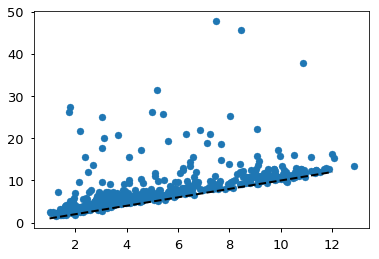

In [44]:
plt.scatter(v1, v2)
x = np.linspace(1, 12)
plt.plot(x, x, '--k', linewidth=2)
#plt.axis([0, 12, 0, 12])

In [28]:
targets = train.RefinedCVTrainedModel() * train.BinConfig()
t91 = train.CVSet().aggr(targets & 'bin_counts=91', cnn91_valid_score='min(cnn_valid_score)')
t61 = train.CVSet().aggr(train.BestModelByBin * train.BinConfig & 'bin_counts=61', cnn61_valid_score='min(cnn_valid_score)')

In [30]:
s1, s2 = (t61 * t91).fetch('cnn61_valid_score', 'cnn91_valid_score')

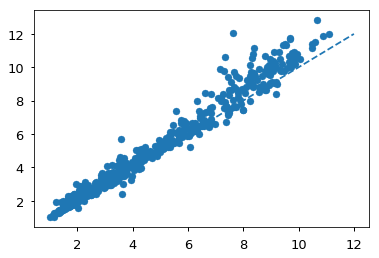

In [32]:
plt.scatter(s1, s2)
x = np.linspace(1, 12)
plt.plot(x, x, '--')

In [12]:
train.CVSet().aggr(targets, cnn_valid_score='min(cnn_valid_score)')

csc_hash hash for clean spike count set,dataset_contrast contrast of the stimulus,cv_seed seed for the cv set,cv_config_id id for config,cnn_valid_score calculated attribute


In [8]:
train.RefinedCVTrainedModel()

csc_hash hash for clean spike count set,dataset_contrast contrast of the stimulus,cv_seed seed for the cv set,cv_config_id id for config,bin_config_id id,model_id model id,param_id ID of parameter,train_seed training seed,cnn_train_score score on train set,cnn_valid_score score on test set,avg_sigma average width of the likelihood functions
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,d509984657be5d4870a7ae4dd3bc4eb2,0e5480f3b207dfcc20d54c41545d85ac,123,9.83599,9.65818,25.3188
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,284e74eab55326f327100ee9acfbf8ca,123,10.6893,11.5924,31.7921
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,3c3b4ae81b1db057e61c3ede60fe65de,123,10.6015,11.5337,28.3762
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,419b157119cc85323ca57d61d333446e,123,10.7725,11.6049,31.7471
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,42e51344040b53b649ea352b5060af5f,8,10.9279,11.4524,31.2785
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,5380fda99488c595dd5c748f8572f43d,92,10.7725,11.6049,31.7685
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,5a622acb3838dc5271700f83ce0433f5,8,10.7725,11.6049,32.0588


In [9]:
dj.config['display.limit'] = 40

In [11]:
init_std, smoothness, learning_rate, dropout

NameError: name 'init_std' is not defined

In [35]:
train.ModelDesign.aggr(train.TrainParam * train.BestModelByBin() & (BinConfig & 'bin_counts=81'), c='count(*)') * train.ModelDesign()

model_id model id,c calculated attribute,hidden1 size of first hidden layer,hidden2 size of second hidden layer
5f158ede88a67605c4a024d6f4cc9824,145,800,800
60993fbe03e405d2e8a3b5ff3a3da0ab,121,400,400
d509984657be5d4870a7ae4dd3bc4eb2,142,1000,1000
e1b77e134717fc53615328dffe1243b8,152,600,600


In [24]:
(train.schema.jobs & 'status = "error"').delete()

In [31]:
(analysis.schema.jobs & 'status = "error"').delete()

In [39]:
train.RefinedCVTrainedModel().size_on_disk

720896

In [27]:
train.schema.jobs & 'timestamp < "2018-05-14 20:00:00"'

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp
__c_v_trained_model,1469c6e771641727a429a33b436d98f9,reserved,=BLOB=,,=BLOB=,eywalker@10.28.3.105,poirot-gpu4,1,14658,2018-05-14 13:29:32
__c_v_trained_model,17efcd5b0442dd9d304f73157482868c,reserved,=BLOB=,,=BLOB=,eywalker@10.28.3.105,poirot-gpu1,1,14650,2018-05-14 13:29:47
__c_v_trained_model,28141c9648b6e55ab6d158f65d8f8acd,reserved,=BLOB=,,=BLOB=,eywalker@10.28.2.179,chronos-gpu1,1,14725,2018-05-14 13:29:44
__c_v_trained_model,2c287a2a9ef5fe230a846f4dae040b75,reserved,=BLOB=,,=BLOB=,eywalker@10.28.2.172,uriel-gpu5,1,14754,2018-05-14 13:29:39
__c_v_trained_model,3cbea4dfecc2145f15fb8c880138afe3,reserved,=BLOB=,,=BLOB=,eywalker@10.28.3.105,poirot-gpu7,1,14721,2018-05-14 13:29:42
__c_v_trained_model,3e852e08a750bf649b5712d8c5a43401,reserved,=BLOB=,,=BLOB=,eywalker@10.28.2.179,chronos-gpu0,1,14720,2018-05-14 13:29:48
__c_v_trained_model,4335b21b65f32fecb78cbb18f54f7562,reserved,=BLOB=,,=BLOB=,eywalker@10.28.2.172,uriel-gpu6,1,14745,2018-05-14 13:29:22


In [ ]:
dropout=0.5, init_std=[0.001, 0.01], lr=0.03, 0.6,  smoothness=[3, 30, 300]

In [5]:
train.ModelDesign()

model_id model id,hidden1 size of first hidden layer,hidden2 size of second hidden layer
5f158ede88a67605c4a024d6f4cc9824,800,800
60993fbe03e405d2e8a3b5ff3a3da0ab,400,400
d509984657be5d4870a7ae4dd3bc4eb2,1000,1000
e1b77e134717fc53615328dffe1243b8,600,600


In [701]:
bin91 = BinConfig() & 'bin_counts = 91'
bin61 = BinConfig() & 'bin_counts = 61'

In [702]:
train.CVTrainedModel() & bin91

csc_hash hash for clean spike count set,dataset_contrast contrast of the stimulus,cv_seed seed for the cv set,cv_config_id id for config,bin_config_id id,model_id model id,param_id ID of parameter,train_seed training seed,cnn_train_score score on train set,cnn_valid_score score on test set,avg_sigma average width of the likelihood functions,model trained model
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,0aad392409ceb50cce0e0b3a8b84fa05,92,10.6649,11.6558,46.5285,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,0e5480f3b207dfcc20d54c41545d85ac,8,10.7725,11.6049,31.3203,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,29634f319de2bd405b376d85d890bfea,92,10.7725,11.6049,30.512,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,4e4a2da6c22c367d1d4b07509b085d84,8,10.7725,11.6049,32.3446,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,51b1a7de5ac47f820aa355e49806df68,123,10.6649,11.6558,46.8918,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,5412df2360e2c86a8b86299fffa123ee,8,10.6649,11.6558,44.9846,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,d0c7574250e956bcac74820fa7dc2643,5f158ede88a67605c4a024d6f4cc9824,5412df2360e2c86a8b86299fffa123ee,123,10.6649,11.6558,46.8918,=BLOB=


In [703]:
train.CVTrainedModel() & bin61

csc_hash hash for clean spike count set,dataset_contrast contrast of the stimulus,cv_seed seed for the cv set,cv_config_id id for config,bin_config_id id,model_id model id,param_id ID of parameter,train_seed training seed,cnn_train_score score on train set,cnn_valid_score score on test set,avg_sigma average width of the likelihood functions,model trained model
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,047217e1d14163a844337caa6cc6aa3e,8,9.78144,9.70109,27.873,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,047217e1d14163a844337caa6cc6aa3e,92,9.78144,9.70109,29.2578,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,047217e1d14163a844337caa6cc6aa3e,123,9.78144,9.70109,29.639,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,04dc52c937a982ec840a91be72f15b64,8,9.78144,9.70109,27.873,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,04dc52c937a982ec840a91be72f15b64,92,9.78144,9.70109,29.2578,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,04dc52c937a982ec840a91be72f15b64,123,9.78144,9.70109,29.639,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,0e5480f3b207dfcc20d54c41545d85ac,8,9.88315,9.69099,24.4149,=BLOB=


In [694]:
LinearRegression.fetch(order_by=', '.join(LinearRegression.primary_key))

array([('9c9248d6b67fe1d8348bc51605658447', '0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7', '0.005', 35, '57eeec0a6974ecb4e9fcf68fab052f7b', array([-1.27228060e-01,  3.86747776e-01,  5.28201223e+00, -2.84183637e+00,
        1.18760593e+00,  2.47414441e+00, -1.51028402e+00,  3.11705614e+00,
        1.41523674e-01,  1.57369753e-01, -4.75338125e-02, -5.64243519e-01,
       -2.92995421e-01,  6.26229927e-02, -1.09528336e+00, -6.54166401e-01,
        8.57490407e-01, -1.22757615e-01, -1.82051915e-01,  1.14798188e-01,
        6.40025847e-01,  4.80829353e-02,  1.51552626e+00, -5.84002381e-01,
        1.14793897e+00,  1.35013326e-01, -1.05385601e+00, -1.74197520e-01,
       -1.25110832e+00,  7.53603833e-02,  2.75184621e-01,  1.03333496e+00,
       -9.03245387e-01,  3.81292363e-01,  1.38437078e-01, -4.21527702e-01,
        7.94166151e-01,  3.79944133e-01, -2.75773012e-01,  3.95599775e+00,
       -1.30362192e-01, -6.63891619e-01,  2.63452541e-02, -1.14363815e-02,
       -1.24242800e+00, -1.51078589e-0

In [692]:
train.CVTrainedModel & (BinConfig() & 'bin_counts = 81')

csc_hash hash for clean spike count set,dataset_contrast contrast of the stimulus,cv_seed seed for the cv set,cv_config_id id for config,bin_config_id id,model_id model id,param_id ID of parameter,train_seed training seed,cnn_train_score score on train set,cnn_valid_score score on test set,avg_sigma average width of the likelihood functions,model trained model
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,ce8082ddcba857eb3996a679d9eff20f,5f158ede88a67605c4a024d6f4cc9824,04dc52c937a982ec840a91be72f15b64,92,10.8407,11.602,40.7772,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,ce8082ddcba857eb3996a679d9eff20f,5f158ede88a67605c4a024d6f4cc9824,0a88024895bbba8eab46904d1bb3505e,123,10.8407,11.602,31.8184,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,ce8082ddcba857eb3996a679d9eff20f,5f158ede88a67605c4a024d6f4cc9824,112cf69ed9543f113cfe7f67150b6c9e,92,10.8407,11.602,37.8917,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,ce8082ddcba857eb3996a679d9eff20f,5f158ede88a67605c4a024d6f4cc9824,112cf69ed9543f113cfe7f67150b6c9e,123,10.8407,11.602,31.8184,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,ce8082ddcba857eb3996a679d9eff20f,5f158ede88a67605c4a024d6f4cc9824,16c6c7e2d9fd7e454a6bf178b6c3241d,92,10.8391,11.5952,37.804,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,ce8082ddcba857eb3996a679d9eff20f,5f158ede88a67605c4a024d6f4cc9824,16e71afff63ad3bc32cf4512569552bf,123,10.8647,11.586,31.7624,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,ce8082ddcba857eb3996a679d9eff20f,5f158ede88a67605c4a024d6f4cc9824,1961f595092b3b0231ec1d73fd2b0cbd,92,10.8407,11.602,37.8917,=BLOB=


In [648]:
train.CVTrainedModel & (BinConfig() & 'bin_counts = 61')

csc_hash hash for clean spike count set,dataset_contrast contrast of the stimulus,cv_seed seed for the cv set,cv_config_id id for config,bin_config_id id,model_id model id,param_id ID of parameter,train_seed training seed,cnn_train_score score on train set,cnn_valid_score score on test set,avg_sigma average width of the likelihood functions,model trained model
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,047217e1d14163a844337caa6cc6aa3e,8,9.78144,9.70109,27.873,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,047217e1d14163a844337caa6cc6aa3e,92,9.78144,9.70109,29.2578,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,047217e1d14163a844337caa6cc6aa3e,123,9.78144,9.70109,29.639,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,04dc52c937a982ec840a91be72f15b64,8,9.78144,9.70109,27.873,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,04dc52c937a982ec840a91be72f15b64,92,9.78144,9.70109,29.2578,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,04dc52c937a982ec840a91be72f15b64,123,9.78144,9.70109,29.639,=BLOB=
0534116fd0aea4c6fdc4b8908c1fa5fd3d48e5b7,0.005,35,57eeec0a6974ecb4e9fcf68fab052f7b,9c9248d6b67fe1d8348bc51605658447,5f158ede88a67605c4a024d6f4cc9824,0e5480f3b207dfcc20d54c41545d85ac,8,9.88315,9.69099,24.4149,=BLOB=


In [585]:
key = {'csc_hash': 'b047337460082b62b44a8bc4ccfb4c400b6c9e95', 'dataset_contrast': '0.9'}

In [586]:
key = {'csc_hash': '2a40a1ed593276618990e54ebcbfa55e71d5a4ee', 'dataset_contrast': '0.005'}

In [663]:
keys = CVSet().fetch('KEY')
#keys = [k for k in keys if float(k['dataset_contrast']) < 0.01]
key = keys[30]

In [664]:
key

{'csc_hash': '116ae91919191b3b084d0067e8431d13d19f759d',
 'cv_config_id': '57eeec0a6974ecb4e9fcf68fab052f7b',
 'cv_seed': 35,
 'dataset_contrast': '0.32'}

In [665]:
train_set, valid_set = (CVSet() & key).fetch_datasets()

train_set, valid_set = (CVSet() & key).fetch_datasets()
bin_width = 1 #float((BinConfig() & key).fetch1('bin_width'))
bin_counts = 101 #int((BinConfig() & key).fetch1('bin_counts'))
clip_outside = True #bool((BinConfig() & key).fetch1('clip_outside'))

train_counts, train_ori = np.concatenate(train_set['counts'], 1).T, train_set['orientation']
valid_counts, valid_ori = np.concatenate(valid_set['counts'], 1).T, valid_set['orientation']

xv, train_bins = binnify(train_ori, delta=bin_width, nbins=bin_counts, clip=clip_outside)
_, valid_bins = binnify(valid_ori, delta=bin_width, nbins=bin_counts, clip=clip_outside)

good_pos = train_bins >= 0
train_counts = train_counts[good_pos]
train_ori = train_bins[good_pos]

good_pos = valid_bins >= 0
valid_counts = valid_counts[good_pos]
valid_ori = valid_bins[good_pos]

train_x = torch.Tensor(train_counts)
train_t = torch.Tensor(train_ori).type(torch.LongTensor)

valid_x = Variable(torch.Tensor(valid_counts))
valid_t = Variable(torch.Tensor(valid_ori).type(torch.LongTensor))

Prepare the data

In [666]:
print('Working!')

train_set, test_set = (CVSet() & key).fetch_datasets()
#bin_width, bin_counts, clip_outside = (BinConfig() & key).fetch1('bin_width', 'bin_counts', 'clip_outside')
bin_counts = 91
bin_width = 1.0
clip_outside = True
delta = bin_width
nbins = bin_counts

train_counts, train_ori = np.concatenate(train_set['counts'], 1).T, train_set['orientation']
valid_counts, valid_ori = np.concatenate(test_set['counts'], 1).T, test_set['orientation']

xv, train_bins = binnify(train_ori, delta=bin_width, nbins=bin_counts, clip=clip_outside)
_, valid_bins = binnify(valid_ori, delta=bin_width, nbins=bin_counts, clip=clip_outside)

good_pos = train_bins >= 0
print('Dropping {} train points'.format(len(good_pos) - good_pos.sum()))
train_counts = train_counts[good_pos]
train_ori = train_bins[good_pos]

good_pos = valid_bins >= 0
print('Dropping {} validation points'.format(len(good_pos) - good_pos.sum()))
valid_counts = valid_counts[good_pos]
valid_ori = valid_bins[good_pos]

Working!
Dropping 1 train points
Dropping 0 validation points


In [667]:
sigmaA = 3
sigmaB = 15
pv = (np.arange(nbins) - nbins//2) * delta
prior = np.log(np.exp(- pv**2 / 2 / sigmaA**2) / sigmaA + np.exp(- pv**2 / 2 / sigmaB**2) / sigmaB)
prior = Variable(torch.from_numpy(prior)).cuda().float()

In [668]:
train_x = torch.Tensor(train_counts)
train_t = torch.Tensor(train_ori).type(torch.LongTensor)

valid_x = Variable(torch.Tensor(valid_counts)).cuda()
valid_t = Variable(torch.Tensor(valid_ori).type(torch.LongTensor)).cuda()

train_dataset = TensorDataset(train_x, train_t)
valid_dataset = TensorDataset(valid_x, valid_t)

In [669]:
def objective(net, x=None, t=None):
    if x is None and t is None:
        x = valid_x
        t = valid_t
    net.eval()
    y = net(x)
    posterior = y + prior
    _, loc = torch.max(posterior, dim=1)
    v =(t.double() - loc.double()).pow(2).mean().sqrt() * delta
    return v.data.cpu().numpy()[0]

## Try linear regression

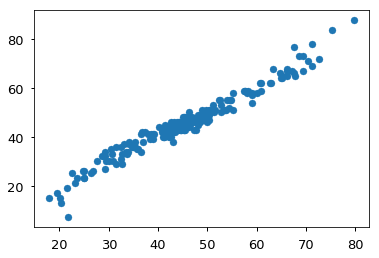

In [670]:
def extend_ones(x):
    return np.concatenate([x, np.ones([x.shape[0], 1])], axis=1)

tc = extend_ones(train_counts)

w = inv(tc.T @ tc + np.diag(np.ones(tc.shape[1]) * 0.0001)) @ tc.T @ train_ori

t_hat = extend_ones(valid_counts) @ w

plt.scatter(t_hat, valid_ori)

In [671]:
np.sqrt(np.mean((t_hat - valid_ori)**2)) * delta

2.5464349249876137

## Fit NN

In [672]:
net = Net(n_output=bin_counts, n_hidden=[600, 600], std=0.001, dropout=0.5)
net.cuda()
loss = nn.CrossEntropyLoss().cuda()

11.983894771967059


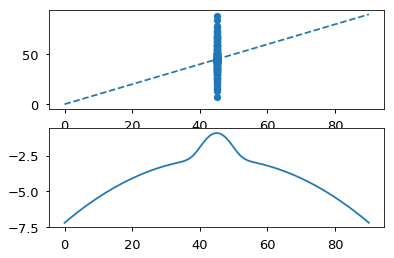

In [673]:
net.eval()
y = net(valid_x)

y = y + prior
val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()

plt.subplot(211)
t_hat = idx.data.cpu().numpy()
plt.scatter(t_hat, valid_ori)
xp = np.arange(nbins)
plt.plot(xp, xp, '--')

print(np.sqrt(np.mean((t_hat - valid_ori)**2)) * delta)

plt.subplot(212)

plt.plot(yd[47])


In [674]:
net.std = 1e-2

set_seed(8)
net.initialize()

alpha = 30 #3e-2 #7e-3 #1e-3


#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.3)
learning_rates = 0.03 * 3.0**(-np.arange(3))

for lr in learning_rates:
    print('\n\n\n\n LEARNING RATE: {}'.format(lr))
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    for epoch, valid_score in early_stopping(net, objective, interval=20, start=100, patience=20, max_iter=300000, maximize=False):
        data_loader = DataLoader(train_dataset, shuffle=True, batch_size=128)
        for x_, t_ in data_loader:
            x, t = Variable(x_).cuda(), Variable(t_).cuda()
            net.train()
            optimizer.zero_grad()
            y = net(x)
            post = y + prior
            val, _ = post.max(1, keepdim=True)
            post = post - val
            #sparcity = y.abs().sum(1).mean()
            conv_filter = Variable(torch.from_numpy(np.array([-0.25, 0.5, -0.25])[None, None, :]).type(y.data.type()))
            
            try:
                smoothness = nn.functional.conv1d(y.unsqueeze(1), conv_filter).pow(2).mean()
            except:
                smoothness = 0
            score = loss(post, t)
            score = score + alpha * smoothness
            score.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print('Score: {}'.format(score.data.cpu().numpy()[0]))
        #scheduler.step()

Setting numpy and torch seed to 8




 LEARNING RATE: 0.03
Score: 3.678403854370117
Score: 3.186973810195923
[120|00/20] ---> 9.793358527320196
Score: 3.0014395713806152
Score: 2.8133697509765625
[140|00/20] ---> 6.008577559776148
Score: 2.527514696121216
Score: 2.4603302478790283
[160|00/20] ---> 5.433167888508603
Score: 2.5283379554748535
Score: 2.446695327758789
[180|00/20] ---> 4.024602451510442
Score: 2.3334150314331055
Score: 2.596737861633301
[200|00/20] ---> 3.77193157561995
Score: 2.3695359230041504
Score: 2.2978734970092773
[220|01/20] -/-> 4.093855963802405
Score: 2.245621681213379
Score: 2.339383840560913
[240|01/20] ---> 2.8040436772999824
Score: 2.138909339904785
Score: 2.379683256149292
[260|01/20] -/-> 3.0741899383128612
Score: 2.24973726272583
Score: 2.374691963195801
[280|02/20] -/-> 3.5882497795842885
Score: 2.211465358734131
Score: 2.2125349044799805
[300|03/20] -/-> 3.088119279868457
Score: 2.113328695297241
Score: 2.212153196334839
[320|03/20] ---> 2.4608522896379

In [675]:
objective(net, Variable(train_x).cuda(), Variable(train_t).cuda())

1.2410450942834494

In [676]:
objective(net, valid_x, valid_t)

1.8862502257556102

In [677]:
import seaborn as sns

In [678]:
yrel = yd / yd.max(axis=1, keepdims=True)

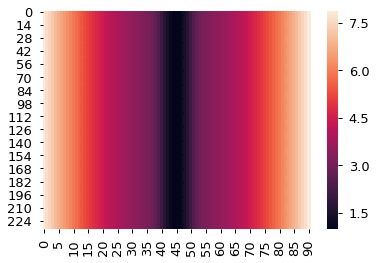

In [679]:
sns.heatmap(yrel)

In [680]:
flat = 1/nbins * np.ones((1, nbins))

In [681]:
flat_mu = (flat * np.arange(nbins)).sum()

In [682]:
ds = (np.arange(nbins) - flat_mu)**2
flat_sigma = np.sqrt(np.sum(ds * flat, axis=1)) * delta

Text(0.5,0.98,'$\\mathbf{E}[\\sigma]$=3.186')

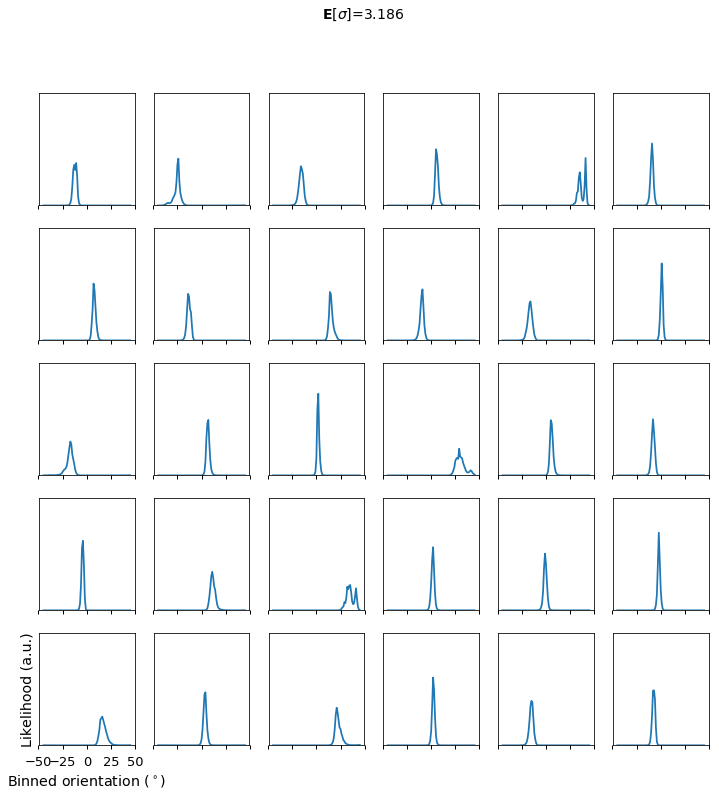

In [683]:
from itertools import count

y = net(valid_x)
#val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()
yd = np.exp(yd)
yd = yd / yd.sum(axis=1, keepdims=True)
ymu = (yd * pv).sum(axis=1)

loc = yd.argmax(axis=1)
ds = (pv - ymu[:, None])**2
ysigma = np.sqrt(np.sum(yd * ds, axis=1)) * delta
avg_sigma = np.mean(ysigma)


n_rows = 5
n_cols = 6
fig, axs = plt.subplots(5, 6, figsize=(12, 12))

for c, ((i, j), ax) in zip(count(), np.ndenumerate(axs)):
    
    ax.plot(pv, yd[c])
    ax.set_ylim([0, 0.5])
    ax.set_yticks([])
    if j == 0 and i == n_rows-1:
        ax.set_ylabel('Likelihood (a.u.)')
        ax.set_xlabel('Binned orientation ($^\circ$)')
    else:
        ax.set_xticklabels([])

fig.suptitle("$\mathbf{{E}}[\sigma]$={:0.3f}".format(avg_sigma), fontsize=14)


In [684]:
from v1_likelihood.utils import binned_stats, binned_group

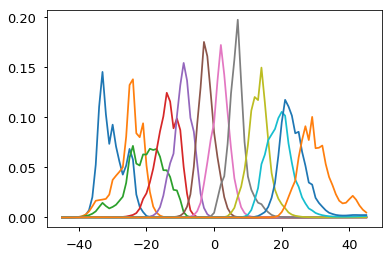

In [685]:
valid_bin = valid_t.data.cpu().numpy().ravel()
valid_ori = pv[valid_bin]
v = np.percentile(valid_ori, np.linspace(0, 100, 15))
v = np.linspace(-30, 30, 13)
binc = 0.5 * (v[1:] + v[:-1])
groups = binned_group(valid_ori, v)
avgLs = []
for g in groups:
    avgL = yd[g].mean(axis=0)
    avgLs.append(avgL)
    plt.plot(pv, avgL)

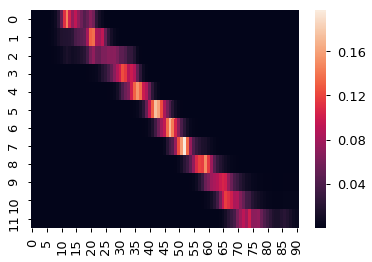

In [686]:
sns.heatmap(avgLs, )

/src/v1_likelihood/v1_likelihood/utils.py:32: RuntimeWarning: Mean of empty slice
  mus = np.nanmean(assign * y, axis=1)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


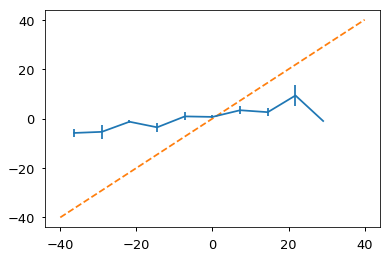

In [644]:
valid_bin = valid_t.data.cpu().numpy().ravel()
valid_ori = pv[valid_bin]
#v = np.percentile(valid_ori, np.linspace(0, 100, 15))
v = np.linspace(-40, 40, 12)
stats = binned_stats(valid_ori, ymu.ravel(), v)
plt.errorbar(stats.binc, stats.mu, stats.sem)
plt.plot(pv, pv, '--')